# Background

We have in our posession a dataset of movies and tv series hosted on Netflix, including IMDB/TMDB ratings, descriptions, titles, actors and their roles. To try to predict IMDB ratings for each movie/series, we will include all numerical variables as well as create some new variables including:

1. Actor/Director predicted ethnicity from name
1. Sentiment score for description of video
1. Sentiment score for title of video

## Data Sources

Netflix dataset:
* https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?datasetId=2178661&sortBy=voteCount

Names/Ethnicity dataset: 
* https://www.kaggle.com/code/residentmario/regional-ethnic-baby-name-popularity-variations/data
* https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TYJKEZ
* https://www.kaggle.com/datasets/fivethirtyeight/fivethirtyeight-most-common-name-dataset `#priority` because its from the US Census

# Imports

In [1]:
import pandas as pd                                       # data processing and handling
import numpy as np                                        # some minor statistical functions
import matplotlib.pyplot as plt                           # accessing plot properties
import seaborn as sns                                     # prettier plots

In [2]:
from sklearn.pipeline import Pipeline                     # for easier processing, and compatibility with gridsearch
from sklearn.preprocessing import (Normalizer,            # scaling of features, gridsearchcv will look for
                    StandardScaler, MinMaxScaler,         # best to use
                    PowerTransformer, MaxAbsScaler)
from sklearn.preprocessing import MultiLabelBinarizer     # to turn a series of lists of strings into dummy variables
from sklearn.feature_selection import VarianceThreshold   # Feature selector

from sklearn.model_selection import (train_test_split,    # to split dataset
                                    GridSearchCV)         # for finding optimal hyperparameters

In [3]:
# ML supervised regressor algorithms
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor        # ensemble method
from sklearn.metrics import mean_squared_error, r2_score  # outcome metrics for regression algorithms

In [4]:
import spacy                                              # sentiment scoring of descriptions and titles
from spacytextblob.spacytextblob import SpacyTextBlob     # pipe support for spacy

In [5]:
from tqdm.notebook import tqdm_notebook as pb             # adding a progressbar to functions, viewable from jupyter
import datetime as dt                                     # handling datetime objects

pb.pandas(desc="")                                        # support for progress bars with df.progress_apply

First things first, data needs to be loaded, cleaned, made ready for our ML algorithms.

In [6]:
# folder that data sources are in
data_loc = 'data'

In [7]:
credits = pd.read_csv(f"{data_loc}/credits.csv") # actor/director dataset
titles = pd.read_csv(f"{data_loc}/titles.csv")   # titles and their properties

# Data Processing

## Cleaning: Titles

In [8]:
titles.sample(1)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1872,tm244174,Okja,MOVIE,A young girl named Mija risks everything to pr...,2017,PG-13,122,"['drama', 'scifi', 'action']","['KR', 'US']",NaN,tt3967856,7.3,116305.0,23.865,7.4


In [9]:
genres = titles[['id','genres']]

In [10]:
genres['genres'].apply(len).sort_values()

4131     2
1805     2
3129     2
3152     2
2998     2
        ..
423     86
717     89
371     93
3636    94
729     96
Name: genres, Length: 5806, dtype: int64

In [11]:
genres.iloc[729,:]

id                                                  ts20429
genres    ['scifi', 'action', 'animation', 'drama', 'wes...
Name: 729, dtype: object

Based on the above, the longest list is in row 729 with 96 characters included for that title. Note that while the `genres` feature looks like it contains a list of strings, really it's a string with brackets, commas, and letters

To have `genres` as a feature variable, it will be dummified:

1. Discard all characters except for letters and numbers
1. Split on the comma to get an actual list of strings
1. Get all unique genres and dummify them, using `MultiLabelBinarizer`

Then repeat the above three steps for the `production_countries` columns, which include the countries that the title was produced in

In [12]:
def keep_only_abc(my_series):
    return my_series.str.replace('[^a-zA-Z]','')

In [13]:
def string_lists_to_lists(my_series):
    return my_series.str.replace('[^a-zA-Z0-9,]', '').str.split(',')

In [14]:
def series_lists_to_dummies(my_series, index):
    mlb = MultiLabelBinarizer()
    new_df = pd.DataFrame(mlb.fit_transform(my_series),columns=mlb.classes_, index=index).reset_index()
    if '' in new_df.columns:
        new_df = new_df.drop('', axis=1)
    return new_df

In [15]:
genres_dummies = series_lists_to_dummies(string_lists_to_lists(genres['genres']), genres.id)
countries_dummies = series_lists_to_dummies(string_lists_to_lists(titles['production_countries']), titles.id)

<ipython-input-13-50b3a373118c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z0-9,]', '').str.split(',')


In [16]:
titles_dummies = titles.merge(genres_dummies)
titles_dummies = titles_dummies.merge(countries_dummies)
titles_dummies.head(2)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,TZ,UA,US,UY,VA,VE,VN,XX,ZA,ZW
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,...,0,0,1,0,0,0,0,0,0,0
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,...,0,0,1,0,0,0,0,0,0,0


Preview shows we were successful!

## Feature Engineering: Ethnicities

The actors dataset does not include ethnicities, but it does include the names of actors and directors. To try to predict the ethnicity of actors/directors we will use three different datasets:

1. Top 1000 baby names from NYC
1. 4250 baby names and their proportional use in different ethnicities from Harvard
1. 15000 surnames and their proportional use in different ethnicities, from the US Census Bureau, provided by 538

In [17]:
credits.sample(4, random_state=61)

,person_id,id,name,character,role
57360,414974,ts222049,Phil Bertelsen,NaN,DIRECTOR
18530,9846,tm176630,Jim Gleason,R.D. Warner,ACTOR
49022,363127,ts236685,Óscar Ortuño,Lucas,ACTOR
8479,222,tm88382,Jennifer Coolidge,Fiona,ACTOR


### Dataset: NYC

In [18]:
baby_nyc = pd.read_csv(f"{data_loc}/baby_names_nyc.csv")
baby_nyc.columns = ['yob', 'gender', 'ethnicity', 'first_name', 'count', 'rank']
baby_nyc.head(3)

,yob,gender,ethnicity,first_name,count,rank
0,2011,FEMALE,HISPANIC,GERALDINE,13,75
1,2011,FEMALE,HISPANIC,GIA,21,67
2,2011,FEMALE,HISPANIC,GIANNA,49,42


First names are made lower case and fed through the `keep_only_abc` function, this is to ensure mispellings and typos are avoided and is an attempt at standardizing names.

In [19]:
baby_nyc['first_name'] = baby_nyc['first_name'].str.lower()
baby_nyc['first_name'] = keep_only_abc(baby_nyc['first_name'])
baby_nyc.head(2)

<ipython-input-12-6016406696e0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


,yob,gender,ethnicity,first_name,count,rank
0,2011,FEMALE,HISPANIC,geraldine,13,75
1,2011,FEMALE,HISPANIC,gia,21,67


Duplicates are dropped from the NYC dataset to avoid duplicate copies of our actors/directors once merged.

1. Sort first alphabetically by first name then by rank
1. Keep the highest ranked value. It's assumed that multiple copies indicate multiple ethinicity values, so the highest ranked is extracted

In [20]:
baby_nyc_nodup = baby_nyc.sort_values(['first_name', 'rank'])
baby_nyc_nodup.head(3)

,yob,gender,ethnicity,first_name,count,rank
12956,2014,MALE,ASIAN AND PACIFIC ISLANDER,aahil,14,54
21549,2014,MALE,ASIAN AND PACIFIC ISLANDER,aahil,14,54
10031,2013,FEMALE,BLACK NON HISPANIC,aaliyah,73,3


In [21]:
baby_nyc_nodup = baby_nyc_nodup.drop_duplicates(subset='first_name', keep='first')
baby_nyc_nodup.head(3)

,yob,gender,ethnicity,first_name,count,rank
12956,2014,MALE,ASIAN AND PACIFIC ISLANDER,aahil,14,54
10031,2013,FEMALE,BLACK NON HISPANIC,aaliyah,73,3
10887,2013,MALE,ASIAN AND PACIFIC ISLANDER,aarav,17,50


In [22]:
baby_nyc_nodup['ethnicity'].unique()

array(['ASIAN AND PACIFIC ISLANDER', 'BLACK NON HISPANIC', 'HISPANIC',
       'BLACK NON HISP', 'WHITE NON HISPANIC', 'WHITE NON HISP',
       'ASIAN AND PACI'], dtype=object)

There are some weird ethinicity values that were cut off in the dataset for some reason these are standardized

In [23]:
def rename_ethnicities(value: str) -> str:
    if type(value) != str:
        return value
    value = value.strip()
    if value == 'WHITE NON HISP':
        return 'WHITE NON HISPANIC'
    elif value == 'ASIAN AND PACI':
        return 'ASIAN AND PACIFIC ISLANDER'
    elif value == 'BLACK NON HISP':
        return 'BLACK NON HISPANIC'
    else:
        return value

In [24]:
baby_nyc_nodup['ethnicity'] = baby_nyc_nodup['ethnicity'].apply(rename_ethnicities)

In [25]:
baby_nyc_nodup['ethnicity'].value_counts()

WHITE NON HISPANIC            536
HISPANIC                      398
BLACK NON HISPANIC            364
ASIAN AND PACIFIC ISLANDER    330
Name: ethnicity, dtype: int64

### Dataset: Harvard Names

The same general strategy as above will be used for our harvard dataset, and then merged

In [26]:
baby_harvard = pd.read_excel(f"{data_loc}/firstnames_harvard.xlsx",sheet_name=1)
baby_harvard.head(3)

,firstname,obs,pcthispanic,pctwhite,pctblack,pctapi,pctaian,pct2prace,Unnamed: 8
0,AARON,3646,2.88,91.607,3.264,2.057,0.055,0.137,NaN
1,ABBAS,59,0.00,71.186,3.390,25.424,0.000,0.000,NaN
2,ABBEY,57,0.00,96.491,3.509,0.000,0.000,0.000,NaN


In [27]:
baby_harvard.columns

Index(['firstname', 'obs', 'pcthispanic', 'pctwhite', 'pctblack', 'pctapi',
       'pctaian', 'pct2prace', 'Unnamed: 8'],
      dtype='object')

This dataset has a different method of presenting ethnicity. Instead of ranks, it gives the percent of survey respondents with that ethnicity. So our strategy is as follows:

1. Create a new ethnicity column, populated with the highest percentage value ethnicity for each row
1. Rename ethnicity columns to be inline with the NYC dataset, by mapping the new dictionary

In [28]:
ethnicity_dict = {
    'pcthispanic':'HISPANIC',
    'pctwhite':'WHITE NON HISPANIC',
    'pctblack':'BLACK NON HISPANIC',
    'pctapi':'ASIAN AND PACIFIC ISLANDER',
    'pctaian':'ASIAN AND PACIFIC ISLANDER',
    'pct2prace':'MULTI ETHNIC'
}

In [29]:
# idxmax will take the maximum value from all rows, and record the correspondent variable
baby_harvard['ethnicity'] = baby_harvard[['pcthispanic', 'pctwhite', 
                                          'pctblack', 'pctapi', 
                                          'pctaian', 'pct2prace']].idxmax(axis=1)

In [30]:
# Map and rename ethnicities
baby_harvard['ethnicity'] = baby_harvard['ethnicity'].map(ethnicity_dict)
baby_harvard['ethnicity'].unique()

array(['WHITE NON HISPANIC', 'ASIAN AND PACIFIC ISLANDER', 'HISPANIC',
       'BLACK NON HISPANIC'], dtype=object)

Mapping was successful, no NaNs

In [31]:
baby_harvard['firstname'].isna().sum()

0

No duplicates confirmed

In [32]:
# standardize names to lower case and letters only
baby_harvard['first_name'] = keep_only_abc(baby_harvard['firstname'].str.lower())

<ipython-input-12-6016406696e0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


In [33]:
baby_harvard.head(4)

,firstname,obs,pcthispanic,pctwhite,pctblack,pctapi,pctaian,pct2prace,Unnamed: 8,ethnicity,first_name
0,AARON,3646,2.880,91.607,3.264,2.057,0.055,0.137,NaN,WHITE NON HISPANIC,aaron
1,ABBAS,59,0.000,71.186,3.390,25.424,0.000,0.000,NaN,WHITE NON HISPANIC,abbas
2,ABBEY,57,0.000,96.491,3.509,0.000,0.000,0.000,NaN,WHITE NON HISPANIC,abbey
3,ABBIE,74,1.351,95.946,2.703,0.000,0.000,0.000,NaN,WHITE NON HISPANIC,abbie


In [34]:
baby_nyc_nodup.merge(baby_harvard, on='first_name',how='right').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4251 entries, 0 to 4250
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   yob          928 non-null    float64
 1   gender       928 non-null    object 
 2   ethnicity_x  928 non-null    object 
 3   first_name   4251 non-null   object 
 4   count        928 non-null    float64
 5   rank         928 non-null    float64
 6   firstname    4251 non-null   object 
 7   obs          4251 non-null   int64  
 8   pcthispanic  4251 non-null   float64
 9   pctwhite     4251 non-null   float64
 10  pctblack     4251 non-null   float64
 11  pctapi       4251 non-null   float64
 12  pctaian      4251 non-null   float64
 13  pct2prace    4251 non-null   float64
 14  Unnamed: 8   0 non-null      float64
 15  ethnicity_y  4251 non-null   object 
dtypes: float64(10), int64(1), object(5)
memory usage: 564.6+ KB


### Dataset: 538/Census

The census dataset is laid out in the same manner as the Harvard dataset, however some values are depicted as `(S)`. After reading the excel sheet it can be assumed that these values are very close to 0, and masked to protect the identity of survey responders.

In [35]:
# NOTE: "(S)" means assumed to be NaN
surnames = pd.read_csv(f"{data_loc}/538_most_common/surnames.csv", na_values='(S)')

In [36]:
ethnicity_dict = {
    'pcthispanic':'HISPANIC',
    'pctwhite':'WHITE NON HISPANIC',
    'pctblack':'BLACK NON HISPANIC',
    'pctapi':'ASIAN AND PACIFIC ISLANDER',
    'pctaian':'ASIAN AND PACIFIC ISLANDER',
    'pct2prace':'MULTI ETHNIC'
}

In [37]:
pct_ethnic = [col for col in surnames.columns if 'pct' in col]
pct_ethnic

['pctwhite', 'pctblack', 'pctapi', 'pctaian', 'pct2prace', 'pcthispanic']

The same strategy is used as for the Harvard dataset:

1. Select the ethnicity label with the highest percentage value
1. Reap the label to match those of the NYC dataset

In [38]:
surnames['ethnicity'] = surnames[pct_ethnic].idxmax(axis=1)
surnames['ethnicity'] = surnames['ethnicity'].map(ethnicity_dict)

In [39]:
surnames['surname'] = keep_only_abc(surnames['name'].str.lower())
surnames.head(2)

<ipython-input-12-6016406696e0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,ethnicity,surname
0,SMITH,1,2376206,880.85,880.85,73.35,22.22,0.40,0.85,1.63,1.56,WHITE NON HISPANIC,smith
1,JOHNSON,2,1857160,688.44,1569.30,61.55,33.80,0.42,0.91,1.82,1.50,WHITE NON HISPANIC,johnson


### Dataset: all names

Now comes the merging of datasets, let's see how many names we were able to estimate ethnicity for!

In [40]:
def calculate_num_names_left(dataset):
    '''
    Purely for informational purposes
    '''
    res = dataset.drop_duplicates(subset=['first_name', 'surname'], keep='first')['ethnicity'].isna()
    nans = res.sum()
    total = len(res)
    print(f"There are {nans} out of a total {total} non-duplicate names still without an assigned ethnicity")
    return None

In [53]:
def combine_ethnicity_columns(dataset):
    '''
    Combines all columns that contain ethnicity data into one column, giving
    preference in abc order of column name so that W > X > Y
    '''
    ethnicity_columns = [col for col in dataset.columns if 'ethnicity' in col]
    if 'ethnicity' in ethnicity_columns:
        ethnicity_columns.remove('ethnicity')
    # preference will be given to the alphabetically first col
    ethnicity_columns.sort()
    dataset['ethnicity'] = dataset[ethnicity_columns[0]].copy()
    for i in range(len(ethnicity_columns)):
        if i == len(ethnicity_columns)-1:
            # drop the extra columns that are no longer needed
            return dataset.drop(ethnicity_columns, axis=1)
        # first instance was copied, so this time it's skipped and filled with
        # the other sources
        dataset['ethnicity'] = dataset['ethnicity'].fillna(dataset[ethnicity_columns[i+1]])

The Netflix dataset of actors/directors is standardized in the same manner as our other dataset with one exception:

1. The some actors/directors have more than two words (Robert De Niro vs Jodie Foster) for a name
1. For these, we will the third word as the last name (Niro)
1. Any `nan` that pop up (they don't have a third word) will be filled in with the second word (Foster)

In [45]:
credits['first_name'] = credits['name'].str.split(' ', expand=True)[0].str.lower()
credits['first_name'] = keep_only_abc(credits['first_name'])

last_names = credits['name'].str.split(' ', expand=True)[[1,2]]
credits['surname'] = last_names[2].fillna(last_names[1])
credits['surname'] = keep_only_abc(credits['surname'].str.lower())
credits.head(2)

<ipython-input-12-6016406696e0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


,person_id,id,name,character,role,first_name,surname
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR,robert,niro
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR,jodie,foster


Time to start merging! Will be done in order of priority:

1. First the US Census dataset of last names
1. Then the Harvard dataset of first names
1. Finally, the NYC top 1000 dataset of first names

In [64]:
combined = credits.merge(surnames[['surname','ethnicity']], on='surname', how='left')
combined.head(2)

,person_id,id,name,character,role,first_name,surname,ethnicity
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR,robert,niro,WHITE NON HISPANIC
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR,jodie,foster,WHITE NON HISPANIC


In [65]:
combined = combined.merge(baby_harvard[['first_name','ethnicity']], 
                          on='first_name', 
                          how='left',
                          suffixes=('_W','_X'))
combined.head(2)

,person_id,id,name,character,role,first_name,surname,ethnicity_W,ethnicity_X
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR,robert,niro,WHITE NON HISPANIC,WHITE NON HISPANIC
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR,jodie,foster,WHITE NON HISPANIC,WHITE NON HISPANIC


In [66]:
combined = combined.merge(baby_nyc_nodup[['first_name','ethnicity']], on='first_name', how='left')
# rename to allow function to prioritize sources
combined['ethnicity_Y'] = combined['ethnicity']
combined = combined.drop('ethnicity', axis=1)
combined.head(2)

,person_id,id,name,character,role,first_name,surname,ethnicity_W,ethnicity_X,ethnicity_Y
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR,robert,niro,WHITE NON HISPANIC,WHITE NON HISPANIC,WHITE NON HISPANIC
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR,jodie,foster,WHITE NON HISPANIC,WHITE NON HISPANIC,NaN


We now have 3 ethincity variables, ranked so that W > X > Y in priority. These will be combined into one `ethnicity` variable using the `combine_ethnicity_columns` function. It's logic is:

1. US Census dataset is used as base ethnicity estimate
1. Any `nan` in the US Census is filled with Harvard dataset estimates
1. Any leftover `nan` are filled in with the NYC dataset estimates

In [67]:
# merge columns and remove unneeded ones
combined = combine_ethnicity_columns(combined)
combined.sample(2, random_state=62)

,person_id,id,name,character,role,first_name,surname,ethnicity
3441,230153,tm12499,Elaine Corral Kendall,Newscaster,ACTOR,elaine,kendall,WHITE NON HISPANIC
48401,16731,tm458585,Craig Brewer,NaN,DIRECTOR,craig,brewer,WHITE NON HISPANIC


Just a double check of how many names are left unassigned to ethnicities using the `calculate_num_names_left` function

In [69]:
ethn_na = calculate_num_names_left(combined)

There are 7022 out of a total 53450 non-duplicate names still without an assigned ethnicity


Finally, let's merge our names dataset with the titles dataset while keeping only the desired variables from names:

1. ID (to merge on)
1. Name (just in case)
1. Role (just in case)
1. Ethnicity (for ML)

In [70]:
# we dont need any of these columns, since the sole purpose was to estimate the
# actor ethnicities and then merge that info with our movies dataset
combined = combined[['id','name','role','ethnicity']].merge(titles_dummies, how='right')

In [71]:
combined.head(2)

,id,name,role,ethnicity,title,type,description,release_year,age_certification,runtime,...,TZ,UA,US,UY,VA,VE,VN,XX,ZA,ZW
0,ts300399,NaN,NaN,NaN,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,...,0,0,1,0,0,0,0,0,0,0
1,tm84618,Robert De Niro,ACTOR,WHITE NON HISPANIC,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,...,0,0,1,0,0,0,0,0,0,0


## Feature Engineering: Decades

The `released_year` variable includes all years from 1940-2022. To make EDA and visualization easier, these will be bucketed into decades

In [72]:
def create_decades(my_series: pd.Series)->pd.Series:
    labeled_series = pd.cut(
        my_series,
        bins=[1940,1950,1960,1970,1980,1990,2000,2010,2020,2030],
        labels=['40s','50s','60s','70s','80s','90s','00s','10s','20s']
    )
    return labeled_series

In [74]:
combined['decades'] = create_decades(combined['release_year'])

### EDA: Ethnicity across the decades

In [76]:
# this df is solely so that we can plot the number of ethnicities per title
temp_df = combined.drop_duplicates(subset=['id','name'])[['id','name','decades','ethnicity','title','role']]
temp_df.groupby(['id','ethnicity']).count()['title'].sort_values()

id         ethnicity                 
tm1063792  WHITE NON HISPANIC              0
tm1000037  BLACK NON HISPANIC              1
ts219895   BLACK NON HISPANIC              1
tm332500   BLACK NON HISPANIC              1
ts21981    ASIAN AND PACIFIC ISLANDER      1
                                        ... 
tm467467   WHITE NON HISPANIC            105
tm158304   WHITE NON HISPANIC            113
tm84613    WHITE NON HISPANIC            139
tm244149   WHITE NON HISPANIC            162
tm32982    WHITE NON HISPANIC            198
Name: title, Length: 10311, dtype: int64

In [79]:
temp_df.sample(2)

,id,name,decades,ethnicity,title,role
13352,tm152413,Jaclyn Victor,00s,WHITE NON HISPANIC,Talentime,ACTOR
63564,tm457410,Ekin Türkmen,10s,NaN,Money Trap,ACTOR


In [73]:
def add_subtext_to_plot(text, ax, y_loc):
    ax.text(x=0.5, y=y_loc, 
            s=text, 
            fontsize=10, 
            alpha=0.75, 
            ha='center', 
            va='bottom', 
            transform=ax.transAxes)

Text(0.5, 0, 'Decade')

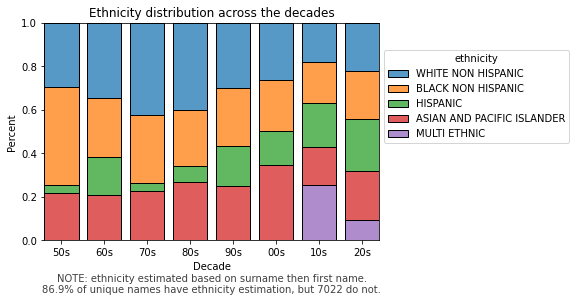

In [80]:
ax = sns.histplot(x='decades', data=temp_df, hue='ethnicity', 
             stat='percent',shrink = 0.8, common_norm=False,
             multiple='fill'
            )
sns.move_legend(ax, bbox_to_anchor=(1,0.9),loc='upper left')
row1 = f'NOTE: ethnicity estimated based on surname then first name.'
row2 = f'{((53450-7022)/53450) * 100:.1f}% of unique names have ethnicity estimation, but 7022 do not.'
add_subtext_to_plot(row1, ax, -0.2)
add_subtext_to_plot(row2, ax, -0.25)
plt.title("Ethnicity distribution across the decades")
plt.xlabel("Decade")

Text(0.5, 1.0, 'Employee ethnicity in films industry based on Netflix catalogue')

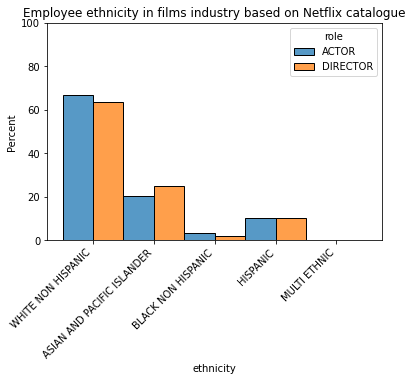

In [59]:
sns.histplot(x='ethnicity', data=temp_df, stat='percent',hue='role', multiple='dodge', common_norm=False)
plt.ylim(0,100)
plt.xticks(horizontalalignment='right', rotation=45)
plt.title('Employee ethnicity in films industry based on Netflix catalogue')

Looks like there is an equal distribution of ethnicities across roles, however White ethnicities make up 60% of all ethnicities overall.

## Feature Engineering: Sentiment Scores

Did the way descriptions and titles were written change across decades? Have they become more evocative? To answer that question, and to include this information in our model, sentiment scores for titles and descriptions using `spacy` is found.

In [81]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

def get_sentiment_score(text):
    '''
    Uses spacy to get the sentiment score of a blob of text
    '''
    if type(text) != str:
        return text
    
    doc = nlp(text)
    sentiment = doc._.blob.polarity
    
    return sentiment

In [82]:
def label_sentiment_score(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

In [84]:
%%time

# NOTE: progress_apply function from tqdm is used to allow for a progress bar. This will take a while.
combined['sentiment_score'] = combined['description'].progress_apply(get_sentiment_score)
combined['sentiment'] = combined['sentiment_score'].progress_apply(label_sentiment_score)

  0%|          | 0/77585 [00:00<?, ?it/s]

  0%|          | 0/77585 [00:00<?, ?it/s]

CPU times: user 15min 11s, sys: 2.67 s, total: 15min 13s
Wall time: 15min 16s


Text(0.5, 1.0, 'Sentiment score of descriptions over the years')

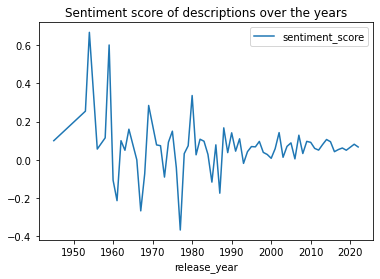

In [85]:
combined.groupby('release_year').mean().reset_index().plot('release_year','sentiment_score')
plt.title("Sentiment score of descriptions over the years")

In [86]:
grpd_plt = combined.groupby('decades').count().reset_index()

Text(0.5, 1.0, 'Number of motion pictures from each decade')

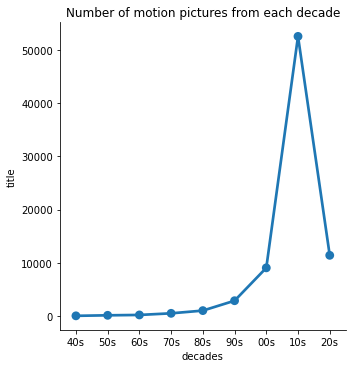

In [87]:
sns.catplot(x='decades', y='title', data=grpd_plt, kind='point')
plt.title('Number of motion pictures from each decade')


Text(0.5, 1.0, 'Distribution of description sentiment scores')

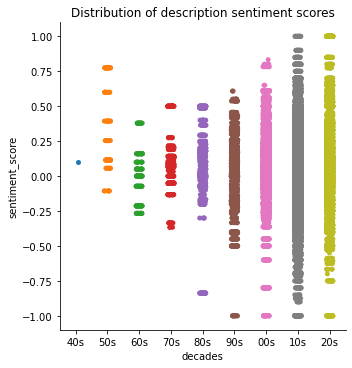

In [88]:
sns.catplot(x='decades', y='sentiment_score', data=combined, kind='strip')
plt.title('Distribution of description sentiment scores')

Looks like as we get closer to the 2020s we get descriptions from across the spectrum: positive, neutral, negative. But we also have more movies and TV series.

Does the same apply to titles?

In [90]:
%%time

combined['sentiment_score_t'] = combined['title'].progress_apply(get_sentiment_score)
combined['sentiment_t'] = combined['sentiment_score_t'].apply(label_sentiment_score)

  0%|          | 0/77585 [00:00<?, ?it/s]

CPU times: user 10min, sys: 5.79 s, total: 10min 6s
Wall time: 8min 55s


Text(0.5, 1.0, 'Sentiment scores of titles over the years')

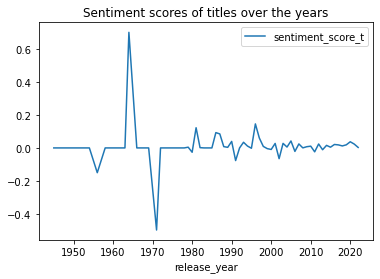

In [91]:
combined.groupby('release_year').mean().reset_index().plot('release_year','sentiment_score_t')
plt.title("Sentiment scores of titles over the years")

Text(0.5, 1.0, 'Distribution of title sentiment scores')

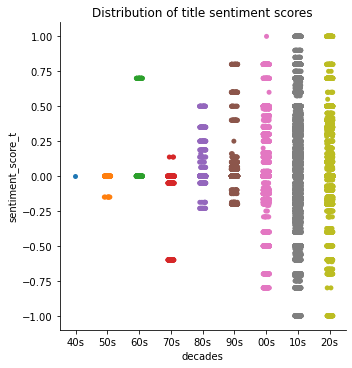

In [92]:
sns.catplot(x='decades', y='sentiment_score_t', data=combined, kind='strip')
plt.title('Distribution of title sentiment scores')

Looks like yes! A similar pattern holds with sentiment scores of titles.

In [93]:
combined[['release_year','imdb_score','tmdb_score']].corr()

,release_year,imdb_score,tmdb_score
release_year,1.000000,-0.144912,0.014813
imdb_score,-0.144912,1.000000,0.689030
tmdb_score,0.014813,0.689030,1.000000


Text(0.5, 1.0, 'Netflix catalogue kept highly rated old films, but all new films')

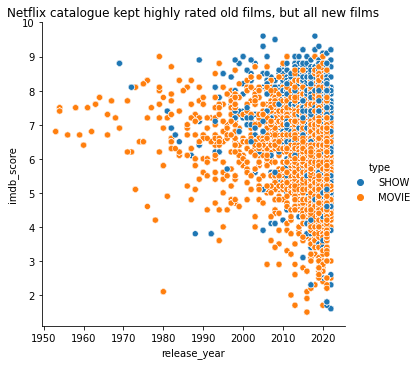

In [96]:
sns.relplot(x='release_year',y='imdb_score', kind='scatter', hue='type', data=combined)
plt.title('Netflix catalogue kept highly rated old films, but all new films')

Text(0.5, 1.0, 'IMDB and TMDB scores are highly correlated (r2 = 0.59)')

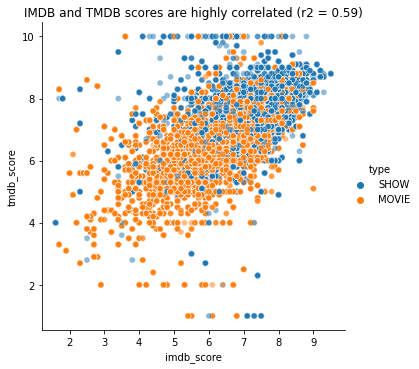

In [100]:
sns.relplot(x='imdb_score', y='tmdb_score', kind='scatter', hue='type', data=combined, alpha=0.5)
plt.title('IMDB and TMDB scores are highly correlated (r2 = 0.59)')

In [101]:
score = len(combined.dropna(subset=['tmdb_score', 'imdb_score']))
print(f"{score} movies have both a TMDB and an IMDB score")

score = combined[combined['imdb_score'].isna()]['tmdb_score'].isna().sum()
print(f"{score} movies have no TMDB score or IMDB score")

score = combined[~combined['imdb_score'].isna()]['tmdb_score'].isna().sum()
print(f"{score} movies have a TMDB score but no IMDB score")

score = combined[~combined['tmdb_score'].isna()]['imdb_score'].isna().sum()
print(f"{score} movies have an IMDB score but no TMDB score")

72388 movies have both a TMDB and an IMDB score
394 movies have no TMDB score or IMDB score
869 movies have a TMDB score but no IMDB score
3934 movies have an IMDB score but no TMDB score


In [102]:
combined['potential_seasons'] = 2022 - combined['release_year']

In [103]:
def cat_pot_seasons(pot_ses):
    if pot_ses < 5:
        return '< 5'
    elif (pot_ses>=5) & (pot_ses<=10):
        return '5-10'
    else:
        return '> 10'

In [104]:
combined['potential_seasons_cat'] = combined['potential_seasons'].apply(cat_pot_seasons)

In [105]:
combined['potential_seasons_left'] = combined['potential_seasons'] - combined['seasons']

Text(0.5, 1.0, 'The number of seasons per show decreases the newer the show is')

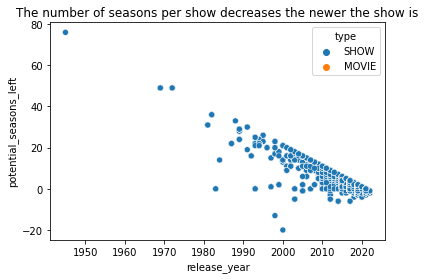

In [106]:
sns.scatterplot(x='release_year',y='potential_seasons_left', data=combined, hue='type')
plt.title('The number of seasons per show decreases the newer the show is')

Makes sense, since Movies don't get the priviledge of seasons

<AxesSubplot:xlabel='runtime', ylabel='seasons'>

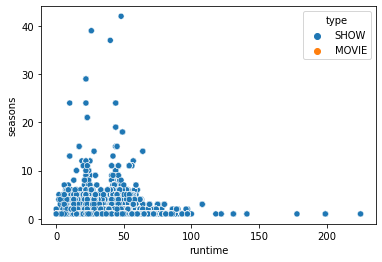

In [108]:
sns.scatterplot(x='runtime', y='seasons', data=combined,hue='type')

<AxesSubplot:xlabel='runtime', ylabel='imdb_score'>

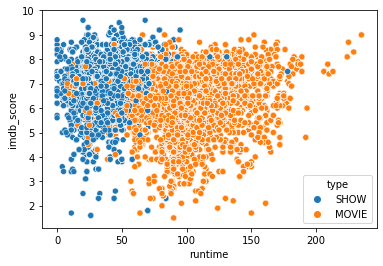

In [109]:
sns.scatterplot(x='runtime', y='imdb_score', data=combined,hue='type')

In [110]:
age_label = {
    'G': 0,
    'PG': 8,
    'PG-13': 13,
    'R': 17,
    'NC-17': 18,
    'TV-Y': 0,
    'TV-Y7': 7,
    'TV-G': 0,
    'TV-PG': 8,
    'TV-14': 14,
    'TV-MA': 17
}

In [111]:
combined['recommended_min_age_viewership'] = combined['age_certification'].map(age_label)

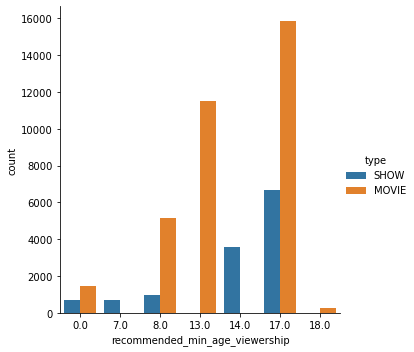

In [113]:
sns.catplot(x='recommended_min_age_viewership', data=combined, kind='count', hue='type')

In [114]:
combined['type_dummy'] = pd.get_dummies(combined['type'])['MOVIE']

In [115]:
combined['age_certification'] = combined['age_certification'].fillna(0)
combined['seasons'] = combined['seasons'].fillna(0)

In [116]:
def save_dataset_as_pkl(dataset, suffix=''):
    date = dt.datetime.now()
    timestamp = f'{date.hour}:{date.minute}, {date.month}/{date.day}/{date.year}'
    try:
        combined.to_pickle(f'{data_loc}/ml_dataset{suffix}.pkl')
        print(f"Successfully saved on {timestamp}")
        return True
    except:
        print(f"Error occurred on {timestamp}")
        return False

In [117]:
save_dataset_as_pkl(combined, suffix='')

Successfully saved on 23:36, 6/30/2022


True

## Findings

# ML Setup

## Target and Feature Columns

In [2]:
data_loc = 'data'

In [3]:
df_og = pd.read_pickle(f"{data_loc}/ml_dataset.pkl")
df_og['ethnicity'] = df_og['ethnicity'].str.lower().str.replace(' ','_')
# dropna, not supported by ML
df_og = df_og.dropna(subset=['sentiment_score_t','sentiment_score', 'imdb_score', 'ethnicity'])

In [4]:
df_og = df_og.merge(pd.get_dummies(df_og['ethnicity']), left_index=True, right_index=True)

In [5]:
unwanted_cols = [
    'id', 'imdb_score', 'sentiment_t', 'sentiment', 
    'imdb_score','tmdb_score','imdb_votes','tmdb_popularity', 
    'potential_seasons_left', 'recommended_min_age_viewership'
]

In [6]:
target_col = 'imdb_score'
feature_cols = df_og.select_dtypes([float, int, 'uint8']).columns

# errors raised are of columns that are not float/int. ID, sentiment_t, sentiment
feature_cols = feature_cols.drop(unwanted_cols, errors='ignore')

In [7]:
X = df_og[feature_cols]
y = df_og[target_col]

In [8]:
X.isna().sum()[X.isna().sum()>0]

Series([], dtype: int64)

No NaNs confirmed

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69, shuffle=True, test_size=0.2)

## Testing with Regression Models

In [13]:
def train_test_predict_score(model):
    m = model()
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"""Results:
    MSE: {mse}
    RMSE: {rmse}
    R2: {r2}
    """)

In [126]:
%%time
train_test_predict_score(LinearRegression)

Results:
    MSE: 0.7747434969039734
    RMSE: 0.8801951470577268
    R2: 0.35051128324389935
    
CPU times: user 8min 37s, sys: 14min 3s, total: 22min 40s
Wall time: 2min 24s


In [14]:
%%time
train_test_predict_score(SVR)

Results:
    MSE: 1.1640308635157262
    RMSE: 1.0789026200337666
    R2: 0.024161009636675557
    
CPU times: user 6min 49s, sys: 0 ns, total: 6min 49s
Wall time: 6min 49s


In [128]:
%%time
train_test_predict_score(DecisionTreeRegressor)

Results:
    MSE: 0.01414480917229464
    RMSE: 0.11893195185607036
    R2: 0.9881420186232137
    
CPU times: user 520 ms, sys: 0 ns, total: 520 ms
Wall time: 517 ms


In [15]:
%%time
train_test_predict_score(RandomForestRegressor)

Results:
    MSE: 0.012014282786241566
    RMSE: 0.10960968381599122
    R2: 0.9899280973112213
    
CPU times: user 33.4 s, sys: 0 ns, total: 33.4 s
Wall time: 33.4 s


## Random Forest Regressor and GridSearch

In [14]:
%%time
pipe = Pipeline([
#    ('pca', PCA(n_components = 4)),
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('regressor', RandomForestRegressor())
], verbose=False)
pipe.fit(X_train, y_train)
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)

print(f"Training set score: {train_score}")
print(f"Testing set score: {test_score}")

Training set score: 0.998300455765183
Testing set score: 0.9897347730436775
CPU times: user 42.2 s, sys: 0 ns, total: 42.2 s
Wall time: 43.1 s


Number of trees, t
Size of Sample, n (Total - N)
Number of variable to sample at each node, m (Total - M)

In [15]:
%%time
parameters = {
    'scaler': [
        StandardScaler(), MinMaxScaler(),
        Normalizer(), MaxAbsScaler()
    ],
    'selector__threshold': [0, 0.1],
    'regressor__n_estimators': [100, 500],
    'regressor__min_samples_split': [2, 10],
    'regressor__oob_score': [True],
    'regressor__max_samples': [25467, 25467/3]
}

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 28.8 µs


In [16]:
%%time
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/jupyter-pomkos/.con

CPU times: user 36min 2s, sys: 3.32 s, total: 36min 6s
Wall time: 36min 4s


CPU times: user 47min 7s, sys: 14.7 s, total: 47min 22s

Wall time: 50min 2s

## Model Evaluation

In [28]:
cv_results = pd.DataFrame().from_dict(grid.cv_results_)
cv_results.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_samples,param_regressor__min_samples_split,param_regressor__n_estimators,param_regressor__oob_score,param_scaler,param_selector__threshold,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,15.804007,0.161640,0.667725,0.004689,29289,2,100,True,StandardScaler(),0,"{'regressor__max_samples': 29289, 'regressor__...",0.967335,0.965214,0.966274,0.001061,8
1,15.803761,0.237395,0.667496,0.007006,29289,2,100,True,StandardScaler(),0.1,"{'regressor__max_samples': 29289, 'regressor__...",0.967735,0.964459,0.966097,0.001638,9
2,15.774039,0.269291,0.657347,0.003142,29289,2,100,True,MinMaxScaler(),0,"{'regressor__max_samples': 29289, 'regressor__...",0.967342,0.964692,0.966017,0.001325,10
3,0.935154,0.009286,0.185361,0.001126,29289,2,100,True,MinMaxScaler(),0.1,"{'regressor__max_samples': 29289, 'regressor__...",0.160758,0.159603,0.160181,0.000577,22


In [51]:
grid.best_score_

0.96760235376249

In [46]:
best_estim = grid.best_estimator_

In [47]:
%%time
best_estim.fit(X_train, y_train)
train_score = best_estim.score(X_train, y_train)
test_score = best_estim.score(X_test, y_test)

print(f"Training set score: {train_score:.2f}")
print(f"Testing set score: {test_score:.2f}")

Training set score: 0.99
Testing set score: 0.98
CPU times: user 2min 50s, sys: 130 ms, total: 2min 50s
Wall time: 2min 50s


Text(16.424999999999997, 0.5, 'Predicted IMDB score')

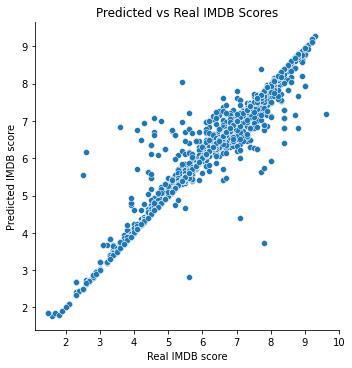

In [43]:
y_predict = pipe.predict(X_test)

sns.relplot(x=y_test, y=y_predict, kind='scatter')
plt.title('Predicted vs Real IMDB Scores')
plt.xlabel('Real IMDB score')
plt.ylabel('Predicted IMDB score')

In [65]:
features = list(X.columns)
selected_features = list()

for feature_list_index in pipe['selector'].get_support(indices=True):
    selected_features.append(features[feature_list_index])

In [84]:
rfr = pipe['regressor']
rfr.oob_score_

0.9829305145513038

In [69]:
features_df = pd.DataFrame()
features_df['features'] = selected_features
features_df['importance'] = pipe['regressor'].feature_importances_ # the higher the more important

In [82]:
features_df.sort_values('importance', ascending=False).iloc[0:25,:].sum()

features      release_yearsentiment_scoreseasonspotential_se...
importance                                             0.901283
dtype: object

The first 25 features, sorted by importance, make up 90% importance in determining the predicted IMDB score

In [83]:
features_df.sort_values('importance', ascending=False).iloc[0:25,:]

,features,importance
0,release_year,0.181509
127,sentiment_score,0.102587
2,seasons,0.099874
128,potential_seasons,0.066993
1,runtime,0.064938
7,documentation,0.045766
8,drama,0.044349
119,US,0.036061
5,comedy,0.031506
129,sentiment_score_t,0.023718


# Export Model

In [50]:
from joblib import dump, load
dump(best_estim, 'netflix_rfr_model.joblib') 

['netflix_rfr_model.joblib']

# Load Model

In [38]:
from joblib import dump, load
pipe = load('netflix_rfr_model.joblib')